# High Speed Datalogger visualization example

This notebook shows how to visualize sensor data that has been collected with High Speed Datalogger (HSD).

HSD is implemented by dedicated firmware ([FP-SNS-DATALOG1](https://www.st.com/en/embedded-software/fp-sns-datalog1.html)) for the [STWIN](https://www.st.com/en/evaluation-tools/steval-stwinkt1b.html) industrial sensor board, by STMicroelectronics.

![](docs/pic/stwin.jpg)

The firsts step is importing the Python HSD module and create an ```hsd``` object. 

```hsd``` must be created by passing a folder where acquisition data has been stored.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import HSD_utils.logger as logger
from HSD.HSDatalog import HSDatalog
import os
from ipywidgets import *

acq = "20220601_11_54_52" # every acquisition is made of several files that are all stored in a folder whose name is in the <YYYYMMDD_HH_MM_SS> format
cwd = os.getcwd()

acq_folder = os.path.join(cwd,"datalogs",acq)
hsd = HSDatalog(acq_folder)

The Python HSD library provides a number of methods to analyze datalogs, accessible through the ```hsd``` object; below we show a few examples.

In [2]:
for i in hsd.get_sensor_list(only_active=True): # getting the list of sensors that were activated in the acquisition being analyzed
    print(i.name)

IIS2MDC
ISM330DHCX


The [ISM330DHCX](https://www.st.com/en/mems-and-sensors/ism330dhcx.html) component includes multiple sensors: a triaxial accelerometer, a triaxial gyroscope and a "Machine Learning Core (MLC)". MLC implements eight programmable decision trees in hardware, so that specific data patterns can be detected.

Let's now see how ISM330DHCX was configured in the acquisition we are using for this example.

In [3]:
sensor_name = "ISM330DHCX"
sensor = hsd.get_sensor(sensor_name)

hsd.present_sensor(sensor) # show parameters of the current acquisition


[ISM330DHCX] - ID: 0
- DESCRIPTOR:
 -- Sensor Type: ACC
 -- Dimensions: 3
 -- Dimensions Labels: ['x', 'y', 'z']
 -- Unit: g
 -- Data Type: int16_t
 -- Supported FS: [2.0, 4.0, 8.0, 16.0]
 -- Supported ODR: [12.5, 26.0, 52.0, 104.0, 208.0, 416.0, 833.0, 1666.0, 3332.0, 6667.0]
 -- Samples per Timestamp info:
   - Min: 0
   - Max: 1000
   - Data Type: int16_t
- STATUS:
 -- isActive: True
 -- ODR: 6667.0
 -- FS: 2.0
 -- samples per timestamp: 1000
 -- sensitivity: 1000
 -- initial_offset: 0.041688

[ISM330DHCX] - ID: 1
- DESCRIPTOR:
 -- Sensor Type: GYRO
 -- Dimensions: 3
 -- Dimensions Labels: ['x', 'y', 'z']
 -- Unit: mdps
 -- Data Type: int16_t
 -- Supported FS: [125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0]
 -- Supported ODR: [12.5, 26.0, 52.0, 104.0, 208.0, 416.0, 833.0, 1666.0, 3332.0, 6667.0]
 -- Samples per Timestamp info:
   - Min: 0
   - Max: 1000
   - Data Type: int16_t
- STATUS:
 -- isActive: False
 -- ODR: 6667.0
 -- FS: 4000.0
 -- samples per timestamp: 1000
 -- sensitivity

The main parameters FS (Full Scale) and ODR (Output Data Rate) can be retrieved as shown below.

In [4]:
print (f"Sensor: {sensor.name}")

s_descriptor_list = sensor.sensor_descriptor.sub_sensor_descriptor
s_status_list = sensor.sensor_status.sub_sensor_status

for i, s in enumerate(s_descriptor_list):
    print(f" --> {s.sensor_type} - ODR: {s_status_list[i].odr} , FS: {s_status_list[i].fs} , SamplesPerTs {s_status_list[i].samples_per_ts}")

Sensor: ISM330DHCX
 --> ACC - ODR: 6667.0 , FS: 2.0 , SamplesPerTs 1000
 --> GYRO - ODR: 6667.0 , FS: 4000.0 , SamplesPerTs 1000
 --> MLC - ODR: 0.0 , FS: 0.0 , SamplesPerTs 1


Let's now create a dataframe which contains accelerometer samples from the [ISM330DHCX](https://www.st.com/en/mems-and-sensors/ism330dhcx.html) component.

In [5]:
df = hsd.get_dataframe('ISM330DHCX','ACC',sample_start=0,sample_end=-1)
df.describe()

,Time,A_x [g],A_y [g],A_z [g]
count,317000.000000,317000.000000,317000.000000,317000.000000
mean,22.530868,-0.008951,-0.026203,1.014499
std,12.984286,0.037190,0.038204,0.035122
min,0.041688,-0.239425,-0.242292,0.788303
25%,11.286096,-0.025498,-0.042395,0.998875
50%,22.530879,-0.008906,-0.026108,1.014735
75%,33.775554,0.007747,-0.010065,1.030595
max,45.020173,0.216611,0.186416,1.212802


Let's now plot this time serie; we first remove the 'Time' column from ```df```, only keep the three axes {x, y, z} and use the plotly library.

**If the number of points to plot is very large, plotly can take some time to load and plot the graph, pls be patient.**

However, once the graph is plotted, we can zoom in and analyze specific parts of our time serie.

In this example, our acquisition contained a 100Hz sinusoid.

In [6]:
acc = df[['A_x [g]','A_y [g]','A_z [g]']]
import plotly.express as px

fig = px.line(acc.head(10000))
fig

Let's now have a look at the power spectral density of our signal.

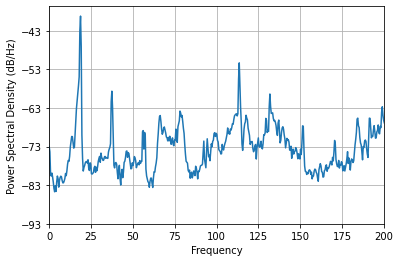

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft

z = acc['A_z [g]'].to_numpy()
z = z - np.mean(z)
sr = 6667

plt.psd(z, 16384, sr)
plt.xlim([0,200])
plt.show()